# Epidemiological dynamics: Practicals

> This section contains practicals based on the [Epidemiological dynamics chapter](epidemiology.ipynb).

```{note} What’s in here
- (3‑3) $R_0$ estimation + vaccination thresholds + core SIR intuition
- (3‑3d) SIR with demography (endemic equilibrium + transients)
- (4‑1) Periodically forced SIR model + stroboscopic diagnostics
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


```{note} Model conventions used here
- $S(t)$, $I(t)$, $R(t)$ denote susceptible, infectious, recovered/removed (fractions or counts).
- In the demography + forcing exercises, time is in years (so rates like $\gamma$ and $\mu$ are per-year).
```

## Problem 3‑3a — Approximate $R_0$ for measles

> (3-3) The calculation of the basic reproductive number

- For measles, the duration of the infectious period is about a week.
  Infected children tend to make 2–3 infectious contacts per day.
  Can you approximate the basic reproductive number?

**Related chapter section:**
- *Basic SIR model (no demography)* (subsection: *Early growth and $R_0$*)


In [2]:
# Back-of-the-envelope estimate
contacts_per_day_low, contacts_per_day_high = 2, 3
infectious_days = 7

R0_low  = contacts_per_day_low  * infectious_days
R0_high = contacts_per_day_high * infectious_days

R0_mid = 2.5 * infectious_days
R0_low, R0_mid, R0_high

(14, 17.5, 21)

**Solution:**  
If one infectious individual makes ~2–3 effective infectious contacts/day for ~7 days, then
$R_0 \approx 14$–$21$ (midpoint ~17.5). This is consistent with measles being very highly transmissible.


## Problem 3‑3b — Vaccination fraction to prevent epidemics

> (3-3) The calculation of the basic reproductive number

- Based on your calculation, what fraction of the population needs to be vaccinated in order to prevent epidemics?

**Related chapter section:**
- *Vaccination and herd immunity*


In [3]:
def herd_immunity_threshold(R0):
    return 1 - 1/R0

for R0 in [R0_low, R0_mid, R0_high]:
    print(R0, herd_immunity_threshold(R0))

14 0.9285714285714286
17.5 0.9428571428571428
21 0.9523809523809523


**Solution:**  
For $R_0$ in the range 14–21, the herd immunity threshold is roughly 93%–95%.  
(Using the midpoint $R_0\approx 17.5$ gives $p_c\approx 94.3\%$.)  


## Problem 3‑3c (starred) — Vaccinating only at age 5

> (3-3) The calculation of the basic reproductive number

Next one perhaps a little too hard.
You need to estimate the fraction of the population under 5.

- *Children normally will have had their first measles vaccination by their second birthday and a booster before their 5th birthday.
  In the first months of their lives, they will carry protection from infection through maternal antibodies.*

  What would be the effect of dropping the first vaccination and relying entirely on the second?
  What fraction of children would you need to immunise at age 5 to prevent a measles epidemic?

**Related chapter sections:**
- *Vaccination and herd immunity*
- *SIR with demography (births and deaths)*


### Solution sketch (order-of-magnitude)

Let $p_{<5}$ be the fraction of the population younger than 5 years.  
If vaccination happens only at age 5, then (ignoring maternal antibodies after a few months) roughly $p_{<5}$ remain unvaccinated at any time, creating a **persistent susceptible pool**.

A crude bound is: even if you vaccinate **100%** of 5‑year‑olds perfectly, the overall susceptible fraction is at least $p_{<5}$.  
To prevent sustained transmission you need $S \lesssim 1/R_0$.

So a necessary condition is:

$$
p_{<5} \le \frac{1}{R_0}.
$$

For measles, $1/R_0$ is about 0.05–0.07. In many high‑income settings, $p_{<5}$ is of similar magnitude (~5–7%), meaning you are already at/above the threshold. Any less‑than‑perfect coverage or vaccine efficacy makes it impossible.

Thus: vaccinating only at age 5 would require **essentially complete (≈100%)** uptake and very high efficacy, and even then it is marginal in many populations — which is why early vaccination is critical for high‑$R_0$ infections like measles.


## Problem 3‑3d — Dynamics of the SIR model with demography

> (3-3) Investigate the dynamics of the SIR model

$$
\begin{aligned}
\frac{dS}{dt} &= \mu (N-S) - \beta\,\frac{SI}{N},\\
\frac{dI}{dt} &= \beta\,\frac{SI}{N} - \gamma I - \mu I,\\
\frac{dR}{dt} &= \gamma I - \mu R.
\end{aligned}
$$

Use parameters $\beta=750$, $\gamma=52$, $\mu=0.0125$.
Choose initial conditions such that $S(0)+I(0)+R(0)=1$.

Next, set parameters to $\beta=1000$, $\gamma=52$, $\mu=0.0125$.
Is there a qualitative change in behaviour?
Is there any cyclic behaviour?
Is the equilibrium stable?

**Related chapter section:**
- *SIR with demography (births and deaths)*


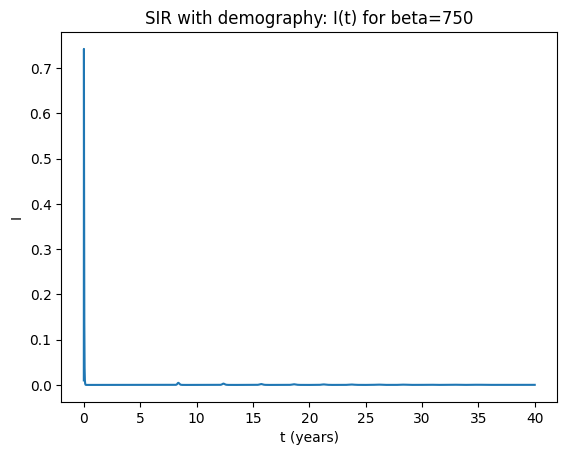

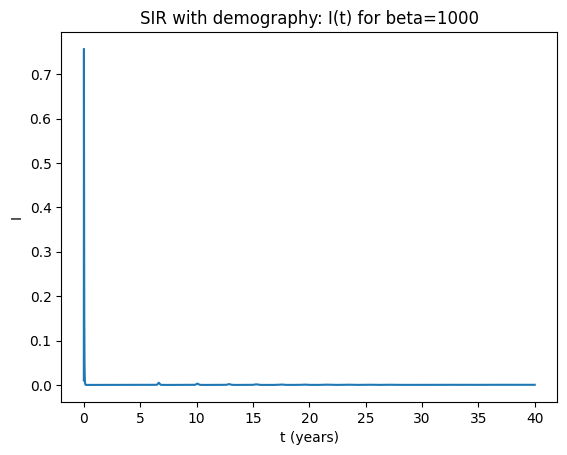

In [4]:
def sir_demo_rhs(t, y, beta, gamma, mu):
    S,I,R = y
    return [mu - beta*S*I - mu*S,
            beta*S*I - gamma*I - mu*I,
            gamma*I - mu*R]

def simulate(beta, gamma=52, mu=0.0125, y0=(0.99,0.01,0.0), t_end=40, n=8000):
    t_eval = np.linspace(0, t_end, n) # years
    sol = solve_ivp(lambda t,y: sir_demo_rhs(t,y,beta,gamma,mu),
                    (0,t_end), list(y0), t_eval=t_eval, rtol=1e-9, atol=1e-12)
    return sol.t, sol.y

for beta in [750, 1000]:
    t,(S,I,R) = simulate(beta=beta)
    plt.figure()
    plt.plot(t,I)
    plt.xlabel("t (years)"); plt.ylabel("I")
    plt.title(f"SIR with demography: I(t) for beta={beta}")
    plt.show()


### Solution notes (3‑3d)

- Both parameter sets have $R_0=\beta/(\gamma+\mu) \gg 1$, so the infection persists and approaches an **endemic equilibrium**.
- Typically the approach shows **damped oscillations** (transient cycles) that decay toward equilibrium.
- Increasing $\beta$ increases $R_0$ and shifts the endemic levels (higher transmission → higher endemic burden), but does not usually create sustained cycles without forcing.


## Problem 4‑1 — Periodically forced SIR

> (4-1) Investigate the periodically forced SIR model

The transmission rate now varies periodically (e.g. seasonal forcing), so that

$$
\begin{aligned}
\frac{dS}{dt} &= \mu(1-S) - \beta(t) S I,\\
\frac{dI}{dt} &= \beta(t) S I - \gamma I - \mu I,
\end{aligned}
$$

with

$$
\beta(t) = b\bigl(1 + \mathrm{amp}\,\sin(\omega t)\bigr).
$$

Use parameters $b=1200$, $\mathrm{amp}=0.08$, $\gamma=50$, $\omega=6.28319$, $\mu=0.0125$.
The frequency parameter in the sine function is chosen such (the value is $2\pi$) that the period is one year.
Investigate the dynamics using time plots and phase plane plots.
Keep running the model for several (10+ years).
What do you see? What is the period of the oscillation?

Now use parameters $b=792$, $\mathrm{amp}=0.08$, $\gamma=50$, $\omega=6.28319$, $\mu=0.0125$.
What do you see? What is the period of the oscillation?

In {cite:t}`Earn2000` cycles of different length are shown.
Can we find these?
To make the period‑3 cycle visible, set the parameters to $b=380$, $\mathrm{amp}=0.08$, $\gamma=50$, $\omega=6.28319$, $\mu=0.0125$.
See whether you get a period‑3 cycle.
If not, fiddle with your initial conditions (I was lucky with $S=0.13$, $I=10^{-6}$).
Look at the phase plane.
How can you tell it is a 3‑cycle from the phase portrait?

For further analysis of cycles in forced epidemic models, see {cite:t}`KrylovaEarn2013`.

**Related chapter section:**
- *Periodically forced SIR (seasonality)*


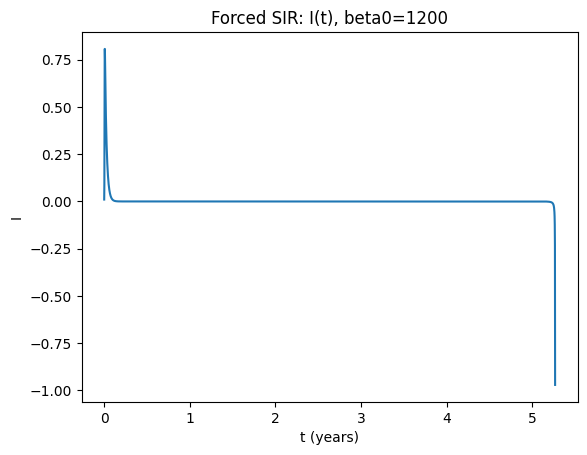

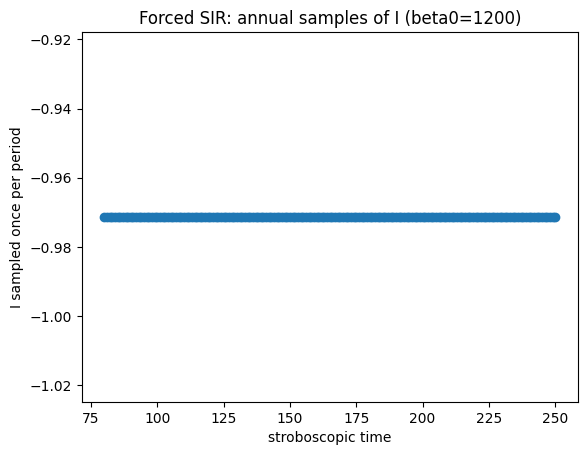

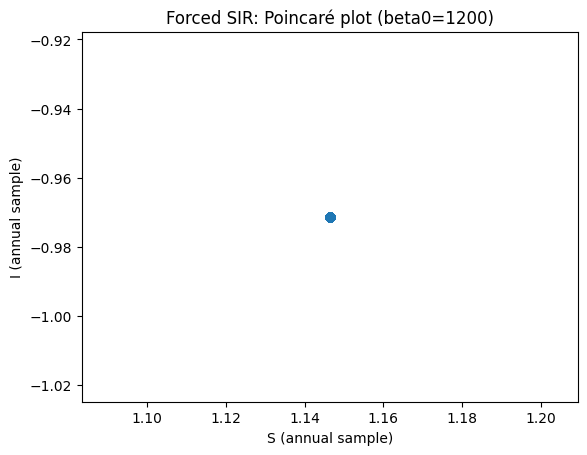

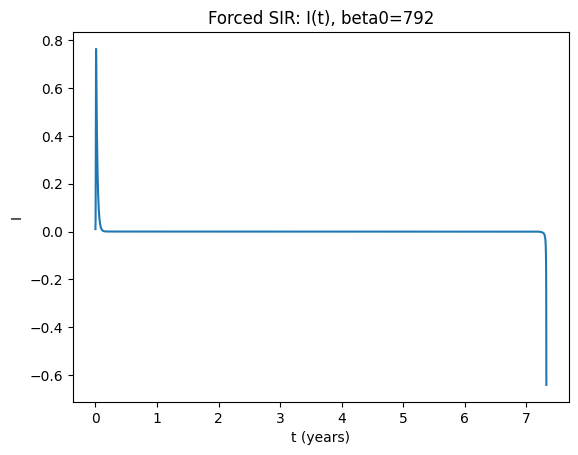

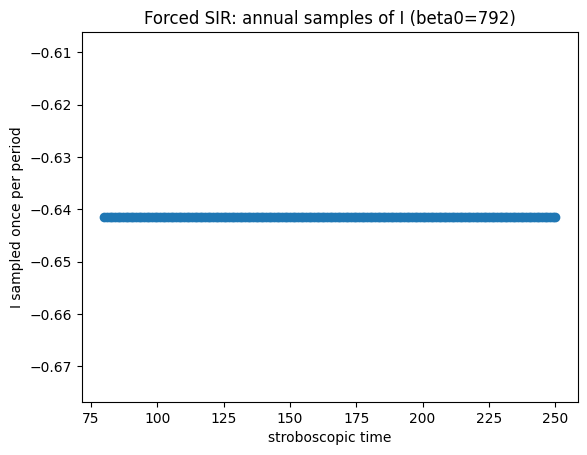

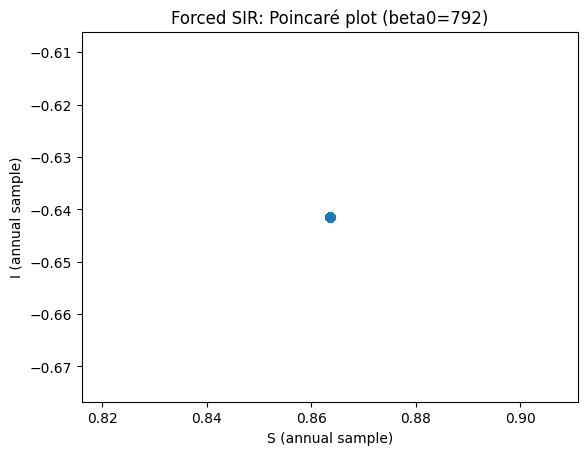

In [5]:
def sir_forced_rhs(t, y, beta0, amp, omega, gamma, mu):
    S,I,R = y
    beta = beta0*(1 + amp*np.sin(omega*t))
    return [mu - beta*S*I - mu*S,
            beta*S*I - gamma*I - mu*I,
            gamma*I - mu*R]

def simulate_forced(beta0, amp=0.08, omega=6.28319, gamma=50, mu=0.0125,
                    y0=(0.99,0.01,0.0), t_end=200, step=0.002):
    t_eval = np.arange(0, t_end+step, step)  # years
    sol = solve_ivp(lambda t,y: sir_forced_rhs(t,y,beta0,amp,omega,gamma,mu),
                    (0,t_end), list(y0), t_eval=t_eval, rtol=1e-8, atol=1e-10)
    return sol.t, sol.y

def stroboscopic_samples(t, X, omega=6.28319, start_year=50, end_year=200):
    # sample once per forcing period
    T = 2*np.pi/omega
    years = np.arange(start_year, end_year, T)
    I = X[1]
    S = X[0]
    I_s = np.interp(years, t, I)
    S_s = np.interp(years, t, S)
    return years, S_s, I_s

for beta0 in [1200, 792]:
    t,X = simulate_forced(beta0=beta0, t_end=250)
    S,I,R = X

    plt.figure()
    plt.plot(t, I)
    plt.xlabel("t (years)"); plt.ylabel("I")
    plt.title(f"Forced SIR: I(t), beta0={beta0}")
    plt.show()

    years, S_s, I_s = stroboscopic_samples(t, X, start_year=80, end_year=250)
    plt.figure()
    plt.plot(years, I_s, marker="o", linestyle="none")
    plt.xlabel("stroboscopic time"); plt.ylabel("I sampled once per period")
    plt.title(f"Forced SIR: annual samples of I (beta0={beta0})")
    plt.show()

    # Stroboscopic phase portrait (S,I)
    plt.figure()
    plt.plot(S_s, I_s, marker="o", linestyle="none")
    plt.xlabel("S (annual sample)"); plt.ylabel("I (annual sample)")
    plt.title(f"Forced SIR: Poincaré plot (beta0={beta0})")
    plt.show()


### How to read the forced-model diagnostics

- If the annual (stroboscopic) samples converge to **one point**, you have a 1‑cycle (period‑1 with the forcing).
- If they alternate between **two points**, you have a 2‑cycle.
- If they repeat among **three points**, you have a 3‑cycle, etc.
- The Poincaré plot in (S,I) makes this visually obvious.

You can also estimate the period directly from peaks in $I(t)$; however, the stroboscopic approach is robust for identifying multi‑year cycles.
